In [345]:
import numpy as np
import matplotlib.pyplot as plt
import math

In [368]:
# Obtain the dataset
from mnist import MNIST
mndata = MNIST('./mnist')
images, labels = mndata.load_training()

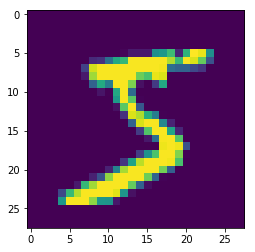

In [369]:
def gen_image(array):
    plt.imshow(np.array(array).reshape((28,28)))
    plt.show()

gen_image(images[0])

In [370]:
# 1. binarize the first 20 images
image_20 = images[0:20]

for image in image_20:
    for pixel in range(len(image)):
        if(image[pixel]<128):
            image[pixel] = -1
        else:
            image[pixel] = 1

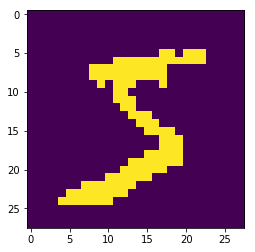

In [371]:
gen_image(image_20[0])

In [372]:
# 2. Add noise to the dataset
import csv
noise = []
file = open('SupplementaryAndSampleData/NoiseCoordinates.csv', 'r')
reader = csv.reader(file)
for row in reader:
    noise.append(row)
file.close()

def add_noise(noise):
    coordinates = {}
    for i in range(20):
        row = (i*2)+1
        col = row+1
        coordinates[i] = []
        for j in range(1, len(noise[row])):
            coordinates[i].append((int(noise[row][j]), int(noise[col][j])))
    
    for i in range(len(image_20)):
        for j in coordDict[i]:
            image_20[i][j[0]*28+j[1]] *= -1  # image size 28*28, flatten index

add_noise(noise)

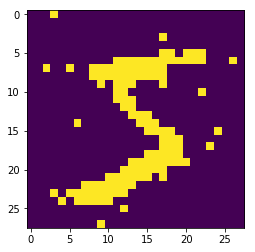

In [373]:
gen_image(image_20[0])

In [374]:
# 3. Building a Boltzman Machine for denoising the images and using Mean-Field Inference

H_theta = 0.8   # hidden
X_theta = 2   # observed

# get update order
order = np.array(np.genfromtxt('SupplementaryAndSampleData/UpdateOrderCoordinates.csv', delimiter=',',
                      skip_header=1, usecols=range(1, 785)))
row_order = []
col_order = []
for i in range(20):
    row_order.append(order[i*2])
    col_order.append(order[i*2+1])
row_order = np.array(row_order, dtype=np.int)
col_order = np.array(col_order, dtype=np.int)

# initial parameters
Q = np.genfromtxt('SupplementaryAndSampleData/InitialParametersModel.csv', delimiter=',')

# Copy Q for each image (all images use same initial Q values)
pi = [np.copy(Q) for _ in range(20)] 

In [353]:
def hidden_neighbors_sum(pi,x,y):
    
    result = 0   
    # boundary check, get all neighbors
    
    if(x > 0):
        result += (2*pi[y][x-1]) - 1   
    if(y > 0):
        result += (2*pi[y-1][x]) - 1
    if (x < 27):  
        result += (2*pi[y][x+1]) - 1
    if (y < 27):
        result += (2*pi[y+1][x]) - 1
    
    result *= H_theta
    
    return result


def observed_neighbors_sum(X, x, y):
    return  X[y][x] * X_theta


In [354]:
def compute_energy(pi,X):
    
    logQ = 0
    logP = 0
    eps = 10**(-10)
    
    for row in range(len(pi)):
        for Q in pi[row]:
            logQ += Q * np.log(Q + eps)
            logQ += (1-Q) * np.log((1-Q) + eps)
    
    for y in range(len(pi)):
        for x in range(len(pi[y])):
            hidden = 0      
            if (x > 0):
                hidden += 2*pi[y][x-1] - 1        
            if (x < 27):
                hidden += 2*pi[y][x+1] - 1              
            if (y > 0):
                hidden += 2*pi[y-1][x] - 1
            if (y < 27):
                hidden += 2*pi[y+1][x] - 1
                
            hidden *= H_theta * (2*pi[y][x]-1)
            observed = observed_neighbors_sum(X, x, y) * (2*pi[y][x]-1)      
            logP += hidden + observed
    
    return logQ - logP

In [355]:
E = np.zeros((20,10))

for it in range(10):    # 10 iterations
    for i in range(20):   # 20 images
        X = np.array(image_20[i]).reshape((28, 28))  # observed value
        E[i][it] = compute_energy(pi[i], X)
        
        for x,y in zip(row_order[i],col_order[i]):
            hidden = hidden_neighbors_sum(pi[i], x, y)
            observed = observed_neighbors_sum(X, x, y)
            
            # update pi
            pi[i][y][x] = (np.exp(hidden+observed)) / (np.exp(hidden+observed)+np.exp(-(hidden+observed)))            
        

In [356]:
image_20_2d = [np.array(image_20[i]).reshape(28, 28) for i in range(20)]
for i in range(20):    
    for x, y in zip(row_order[i],col_order[i]):
        if(pi[i][y][x] >= 0.5):
            image_20_2d[i][y][x] = 1
        else:
            image_20_2d[i][y][x] = 0

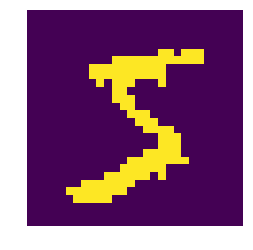

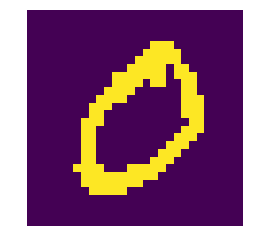

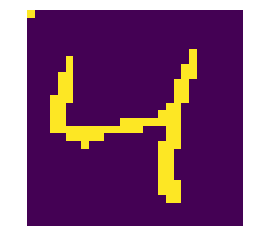

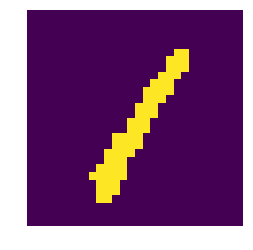

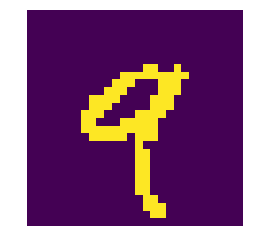

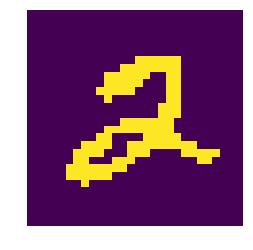

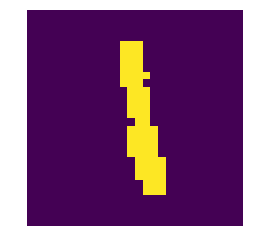

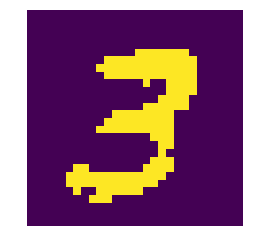

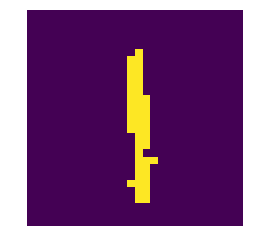

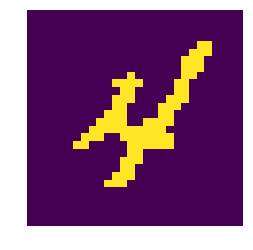

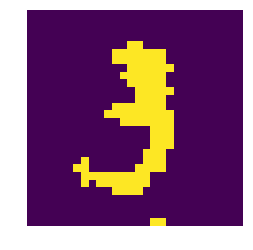

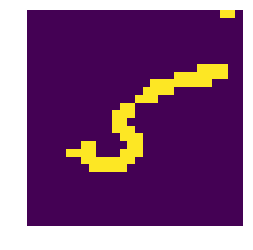

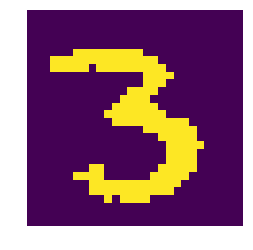

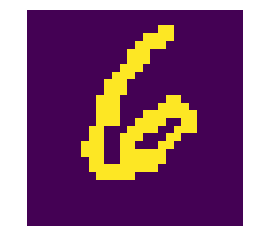

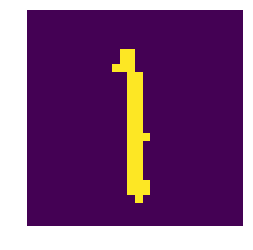

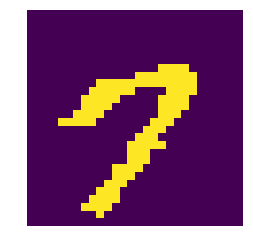

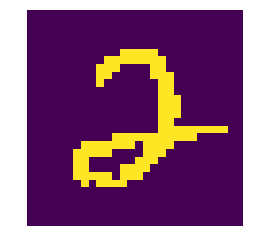

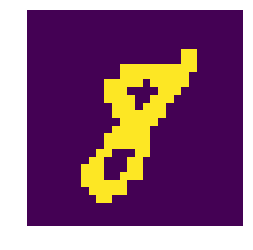

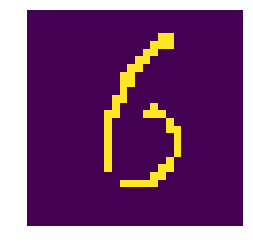

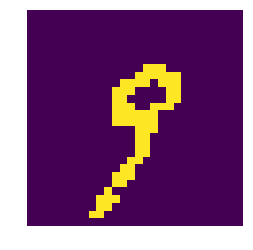

In [360]:
def save_image(image):
    fig = plt.figure(frameon=False)
    fig.set_size_inches(3, 3)
    ax = plt.Axes(fig, [0,0,1,1])
    ax.set_axis_off()
    fig.add_axes(ax)
    ax.imshow(image)
    fig.savefig('image'+str(i+1)+'.png', dpi=28)    
    plt.show() 
    
for i in range(20):
    save_image(image_20_2d[i])

In [363]:
# write energy to csv
energy = []
energy.append([E[10][0], E[10][1]])
energy.append([E[11][0], E[11][1]])        
np.savetxt("energy.csv", energy, delimiter=",") 

In [367]:
# reconstructed images
image = [[] for _ in range(28)]
for row in range(28):
    for i in range(10, 20):
        image[row].extend(image_20_2d[i][row])
np.savetxt("denoised.csv", image, fmt='%d', delimiter=",")   